## Initial LOB EDA

This Notebook outlines the initial EDA carried out on the LOB data. Initially the code has been written on a small sample of the full LOB dataset. To ensure no trends or outliers are missed this EDA will need to be run against the full dataset.

## Contents

- [Load Data](#Load-Data)<br> 
- [Data Types](#Data-Types)<br>
- [Nulls](#Nulls)<br>
- [EDA](#EDA)<br>
- [Outliers](#Outliers)<br>
- [Financial Technical Indicators](#Financial-Technical-Indicators)<br>

In [81]:
#brand colours- #1A7B99(Lightl Blue) #35210D(Brown) #101820(Dark Blue)

## Load Data

In [82]:
#import required libraries
import pandas as pd
import numpy as np
import ast 

In [83]:
#load sample csv
sample_csv = 'data/output/lob_output_data.csv' # define path to sampel data

lob = pd.read_csv(sample_csv)

In [84]:
#dataset dimensions
lob.shape

(41238693, 6)

In [85]:
#dataset info
lob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41238693 entries, 0 to 41238692
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Exchange   object 
 2   Bid        object 
 3   Ask        object 
 4   Date       object 
 5   Mid_Price  float64
dtypes: float64(2), object(4)
memory usage: 1.8+ GB


In [86]:
#visual look at first 5 rows
lob.head()

,Timestamp,Exchange,Bid,Ask,Date,Mid_Price
0,0.000,Exch0,[],[],2025-05-13,NaN
1,1.612,Exch0,"[[1, 1]]",[],2025-05-13,NaN
2,2.170,Exch0,"[[1, 1]]","[[181, 2]]",2025-05-13,91.0
3,2.449,Exch0,"[[2, 1]]","[[181, 2]]",2025-05-13,91.5
4,2.945,Exch0,"[[3, 1]]","[[181, 2]]",2025-05-13,92.0


In [87]:
#reorder cols
order= ['Timestamp', 'Date', 'Exchange','Bid', 'Ask', 'Mid_Price']
lob =lob[order]

 [Return to contents](#Contents)<br>

## Data Types

In [88]:
#convert 'Date' to datetime
lob['Date'] = pd.to_datetime(lob['Date'])

In [89]:
#check if Bid/ Ask are actual lists
print(lob['Bid'].apply(type).unique())
print(lob['Ask'].apply(type).unique())

[<class 'str'>]
[<class 'str'>]


In [90]:
#convert to Bid/Asks to lists
lob['Bid'] = lob['Bid'].apply(ast.literal_eval)
lob['Ask'] = lob['Ask'].apply(ast.literal_eval)

In [91]:
#check if Bid/ Ask are actual lists
print(lob['Bid'].apply(type).unique())
print(lob['Ask'].apply(type).unique())

[<class 'list'>]
[<class 'list'>]


All other types fine but we might want to convert exchange to a category dtype- some benefit re memory/speed?

 [Return to contents](#Contents)<br>

## Nulls

In [92]:
#how many NaN/null in mid price?
missing_mid_price_count = lob['Mid_Price'].isnull().sum()

print(f'Missing "Mid_Price" values: {missing_mid_price_count} ({missing_mid_price_count/len(lob):.4f}% of the sample)')

Missing "Mid_Price" values: 8941 (0.0002% of the sample)


How should we handle missing values?

In [93]:
#drop missing rows as represents small % of sample (i)
lob = lob.dropna(subset=['Mid_Price'])

In [94]:
#if large portion of whole dataset we should consider interpolation
#lob['Mid_Price'].interpolate(method='linear', inplace=True)

In [95]:
#check for rows where both 'Bid' and 'Ask' are empty lists
empty_bid_ask = lob.apply(lambda row: (not row['Bid']) and (not row['Ask']), axis=1)
empty_bid_ask_count = empty_bid_ask.sum()

print(f'Missing "Bid/Ask" values: {empty_bid_ask_count} ({empty_bid_ask_count/len(lob):.4f}% of the sample)')

Missing "Bid/Ask" values: 0 (0.0000% of the sample)


In [96]:
#not sure why this isn't working- I can visually see an empty list in the top row yet can't identify it
#Ah so empty containers doens't necessarily return as a null 
empty_bid_ask = lob.apply(lambda row: row['Bid'] == [] and row['Ask'] == [], axis=1)
empty_bid_ask_count = empty_bid_ask.sum()

print(f'Missing "Bid/Ask" values: {empty_bid_ask_count} ({empty_bid_ask_count/len(lob):.4f}% of the sample)')

Missing "Bid/Ask" values: 0 (0.0000% of the sample)


Ok I think I actually removed these types when I removed the NaN for mid_price! panic over and also where Ask OR Bid is []

There are no missing Timestamp, Exhange or Date values

In [97]:
lob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41229752 entries, 2 to 41238692
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  float64       
 1   Date       datetime64[ns]
 2   Exchange   object        
 3   Bid        object        
 4   Ask        object        
 5   Mid_Price  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.2+ GB


 [Return to contents](#Contents)<br>

## EDA

### Univariate

_Date_

In [98]:
#range
date_min = lob['Date'].min()
date_max = lob['Date'].max()

print(f"Date range- {date_min.date()} to {date_max.date()}")

Date range- 2025-01-02 to 2025-07-01


In [99]:
#how many unique dates
unique_dates = lob['Date'].nunique()

print(f"Unique dates- {unique_dates}") #will be small as sample

Unique dates- 125


In [100]:
#freq of dates 
date_counts = lob['Date'].value_counts()
most_common_date = date_counts.idxmax()
frequency_most_common_date = date_counts.max()

print(f"Most common date- {most_common_date.date()} (Frequency- {frequency_most_common_date})")

Most common date- 2025-01-09 (Frequency- 371630)


In [101]:
# Group by month and count unique dates
unique_dates_by_month = lob.groupby(lob['Date'].dt.month)['Date'].nunique()

unique_dates_by_month

# Next step is to check for missing dates

Date
1    22
2    20
3    21
4    20
5    20
6    21
7     1
Name: Date, dtype: int64

_Exchange_

In [102]:
#how many unique values
unique_exchange = lob['Exchange'].nunique()

print(f"Unique exchange values- {unique_exchange}")

Unique exchange values- 1


In [103]:
#suggest delete this column if whole data set also has 1 unique value
#lob = lob.drop('Exchange', axis=1)

_Timestamp, Seconds_

In [104]:
#how many unique values
unique_timestamp = lob['Timestamp'].nunique()

print(f"Unique timestamp values- {unique_timestamp}")

Unique timestamp values- 987063


In [105]:
#range
timestamp_range = lob['Timestamp'].max() - lob['Timestamp'].min()

print(f"Max timestamp- {lob['Timestamp'].max()}  Min timestamp-{lob['Timestamp'].min()}")
print(f"Range of timestamp- {timestamp_range}")

Max timestamp- 30599.976  Min timestamp-0.434
Range of timestamp- 30599.541999999998


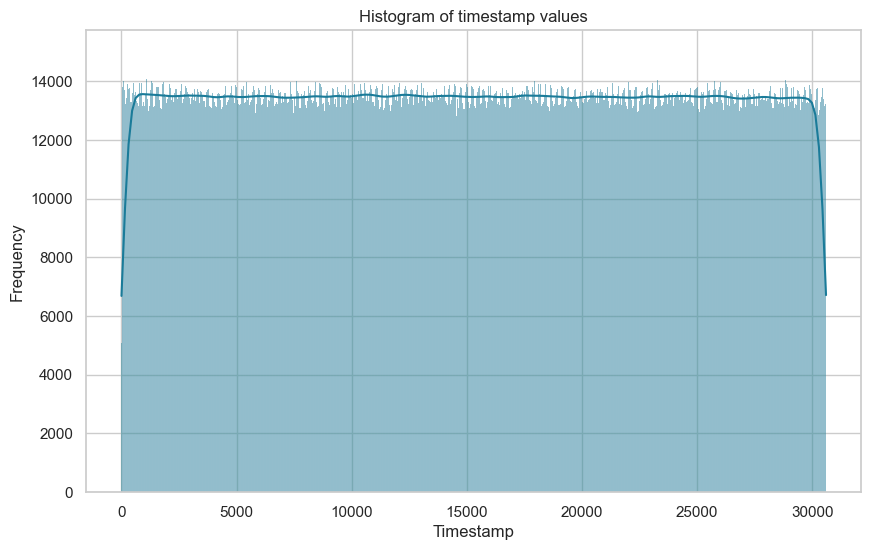

In [106]:
#what is the distribution?
#import required libraries
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

#histogram
plt.figure(figsize=(10, 6))
sns.histplot(lob['Timestamp'], kde=True, color='#1A7B99', binwidth=10)
plt.title('Histogram of timestamp values')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show() 

Relatively uniform distirbution across most of the range, with a consistent frequency- suggests timestamps are evenly spaced over time for majority of data. Noticeable drops at start and end of range- could suggest fewer events/ data points are recorded here. Some spike in frequency at regular intervals- could indicate periodic activity within the data. Uniformity of central range shown again by KDE stability. Suggest explore extremeties of range for outliers.

In [107]:
std_dev = lob['Timestamp'].std() #spread
skewness = lob['Timestamp'].skew() #asymmetry
kurtosis = lob['Timestamp'].kurtosis() #tailedness

print(f"Standard deviation- {std_dev:.4f}")
print(f"Skewness- {skewness:.4f}")
print(f"Kurtosis- {kurtosis:.4f}")

Standard deviation- 8831.4534
Skewness- 0.0011
Kurtosis- -1.1995


Std dev shows wide range which is reasonable given the context. Skewness very close to 0 which means timestamp is very symmetrical. Slightly negative means there is a slightly longer tail on the left hand side. Platykurtic kurtosis level (less than zero)so distribution has lighter tails and is less peaked than normal distribution. Fewer outlier to be found than would be expected with normal. 

To go beyond timestamp we can investigate ticktime, the interval between entries in the LOB.

In [108]:
# Sort DataFrame by date
lob = lob.sort_values(['Date','Timestamp'])

# Calculate the difference between Timestamps (Tick Time) grouped by day 
lob['Tick_Time'] = lob.groupby('Date')['Timestamp'].diff()

lob.head()

,Timestamp,Date,Exchange,Bid,Ask,Mid_Price,Tick_Time
25781999,1.333,2025-01-02,Exch0,"[[1, 6]]","[[800, 1]]",400.5,NaN
25782000,1.581,2025-01-02,Exch0,"[[1, 6]]","[[799, 1]]",400.0,0.248
25782001,1.643,2025-01-02,Exch0,"[[1, 6]]","[[798, 1]]",399.5,0.062
25782002,1.736,2025-01-02,Exch0,"[[261, 1], [1, 6]]","[[798, 1]]",529.5,0.093
25782003,1.984,2025-01-02,Exch0,"[[261, 1], [1, 6]]","[[797, 1]]",529.0,0.248


In [109]:
# Identify NaN Tick Time
missing_tick_time_count = lob['Tick_Time'].isnull().sum()

print(f'Number of missing tick times: {missing_tick_time_count} ({missing_tick_time_count/len(lob):.4f}% of the sample)')

Number of missing tick times: 125 (0.0000% of the sample)


In [110]:
# Full descriptive analytics of ticktime
lob['Tick_Time'].describe()

count    4.122963e+07
mean     9.276401e-02
std      7.763393e-02
min      3.100000e-02
25%      3.100000e-02
50%      6.200000e-02
75%      1.240000e-01
max      7.564000e+00
Name: Tick_Time, dtype: float64

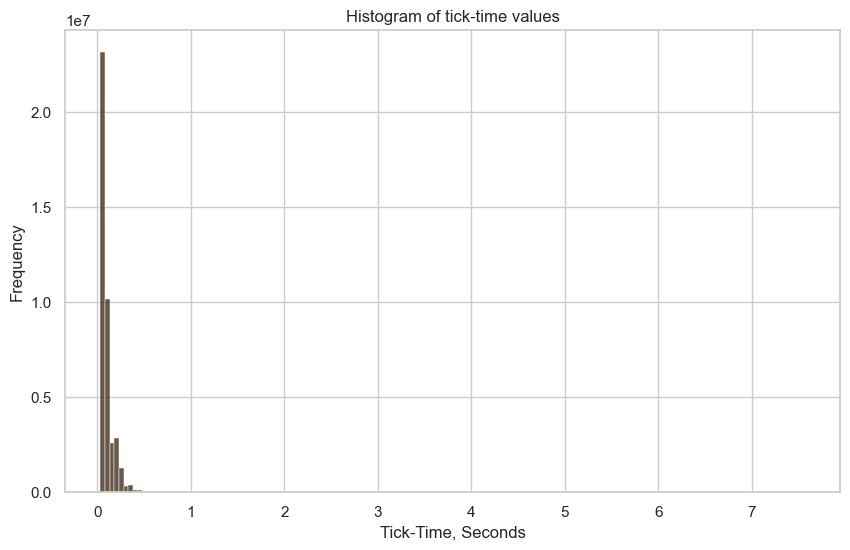

In [111]:
# Create a histogram of the Tick Times
plt.figure(figsize=(10, 6))
sns.histplot(lob['Tick_Time'], color='#35210D', binwidth=0.05)
plt.title('Histogram of tick-time values')
plt.xlabel('Tick-Time, Seconds')
plt.ylabel('Frequency')
plt.show() 

_Bid/ Ask_

In [112]:
#num bids and asks
num_bids = lob['Bid'].apply(len)
num_asks = lob['Ask'].apply(len)

print("Number of bids-", num_bids.describe().round(2))
print("Number of asks-", num_asks.describe().round(2))

Number of bids- count    41229752.00
mean            7.69
std             2.15
min             1.00
25%             6.00
50%             8.00
75%             9.00
max            16.00
Name: Bid, dtype: float64
Number of asks- count    41229752.00
mean            5.44
std             1.65
min             1.00
25%             4.00
50%             5.00
75%             6.00
max            15.00
Name: Ask, dtype: float64


In [113]:
#avg bid and ask prices (assuming [price, quantity])
avg_bid_price = lob['Bid'].apply(lambda x: np.average(
    [item[0] for item in x], weights=[item[1] for item in x]) if x else np.nan)
avg_ask_price = lob['Ask'].apply(lambda x: np.average(
    [item[0] for item in x], weights=[item[1] for item in x]) if x else np.nan)

print("Average bid price-", avg_bid_price.describe().round(2))
print("Average ask price-", avg_ask_price.describe().round(2))

Average bid price- count    41229752.00
mean          160.36
std            72.09
min             1.00
25%           100.62
50%           138.74
75%           222.95
max           382.88
Name: Bid, dtype: float64
Average ask price- count    41229752.00
mean          407.35
std           100.55
min            95.00
25%           340.18
50%           407.27
75%           470.79
max           800.00
Name: Ask, dtype: float64


In [114]:
#spread (assuming best bid is highest price and best ask is lowest price)
spread = lob.apply(lambda row: (min(item[0] for item in row['Ask']) - max(
    item[0] for item in row['Bid'])) if row['Bid'] and row['Ask'] else np.nan, axis=1)

print("Spread-", spread.describe().round(2))

Spread- count    41229752.00
mean           41.97
std            73.99
min             1.00
25%             4.00
50%            12.00
75%            44.00
max           799.00
dtype: float64


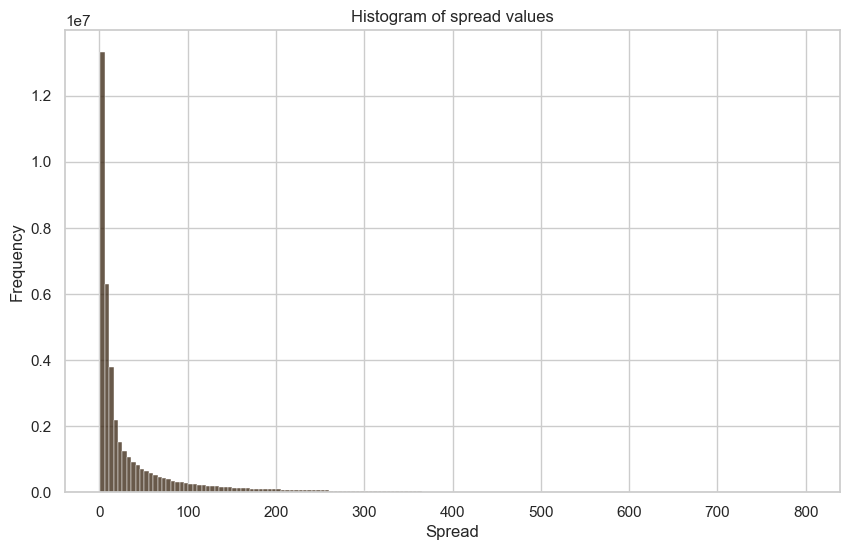

In [115]:
# Create a histogram of the spread
plt.figure(figsize=(10, 6))
sns.histplot(spread, color='#35210D', binwidth=5)
plt.title('Histogram of spread values')
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.show() 

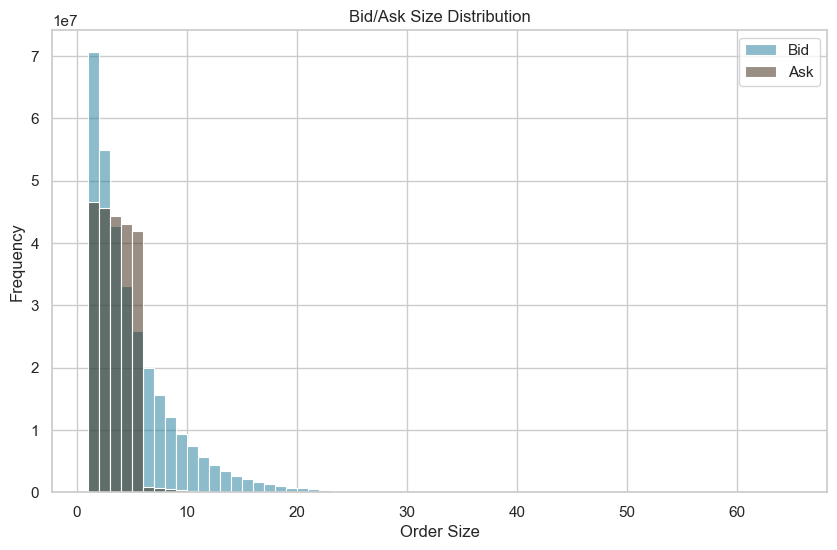

In [116]:
#frequency distribution of bid/ask sizes (if second element is the size)
bid_sizes = [item[1] for sublist in lob['Bid'].tolist() for item in sublist]
ask_sizes = [item[1] for sublist in lob['Ask'].tolist() for item in sublist]

# print("\nBid Sizes Frequency distribution:\n", pd.Series(bid_sizes).value_counts())
# print("Ask Sizes Frequency distribution:\n", pd.Series(ask_sizes).value_counts())

plt.figure(figsize=(10, 6))
# Plotting bid histogram
sns.histplot(bid_sizes, binwidth=1, color='#1A7B99', alpha=0.5, label='Bid')
# Plotting ask histogram
sns.histplot(ask_sizes, binwidth=1, color='#35210D', alpha=0.5, label='Ask')

plt.xlabel('Order Size')
plt.ylabel('Frequency')
plt.title('Bid/Ask Size Distribution')
plt.legend(loc='upper right')

plt.show()

_Mid_Price_

In [117]:
#describe
lob['Mid_Price'].describe().round(2)

count    41229752.00
mean          227.37
std            82.47
min            47.00
25%           155.00
50%           211.00
75%           304.00
max           593.00
Name: Mid_Price, dtype: float64

Median is quite close to the mean which suggests the data might be somewhat symmetrically distributed. The range is quite large (~423) so we can observe a wide variety here. As mean is slightly greater we can assume right-skewed so potentially some high outliers to deal with. Relatively small std dev suggests relatively narrow band around the mean.

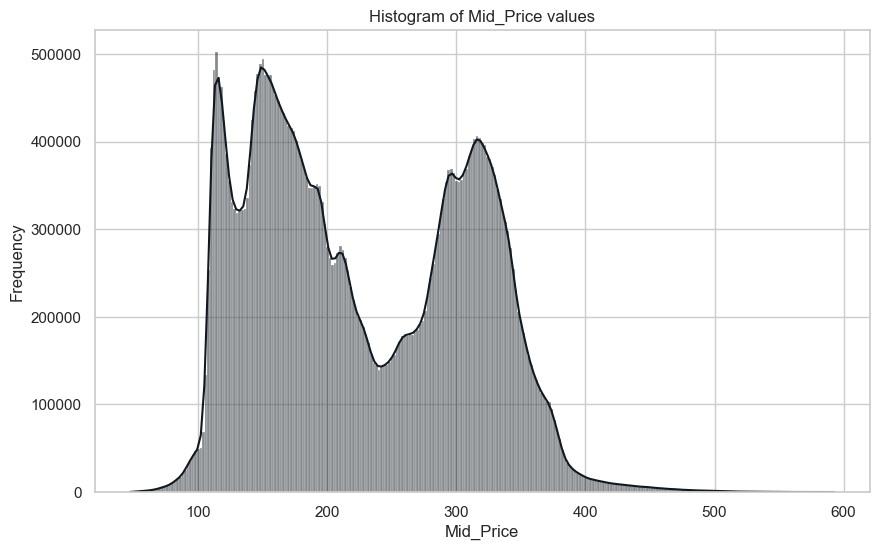

In [118]:
#what's the distribution look like?
#import required libraries
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

#histogram
plt.figure(figsize=(10, 6))
sns.histplot(lob['Mid_Price'], kde=True, color='#101820', binwidth=2)
plt.title('Histogram of Mid_Price values')
plt.xlabel('Mid_Price')
plt.ylabel('Frequency')
plt.show() 

Strong central beak around the 300 mark and narrow relative spread around confirms what we saw in the stats. Longer tail on the right- recommend assess here for outliers. Some points maybe to investigate around the middle that extend outside of the central peak. I feel this represents a price without large levels of volatility. 

In [119]:
skewness = lob['Mid_Price'].skew() #asymmetry
kurtosis = lob['Mid_Price'].kurtosis() #tailedness

print(f"Skewness- {skewness:.4f}")
print(f"Kurtosis- {kurtosis:.4f}")

Skewness- 0.2570
Kurtosis- -1.1147


Skewness of greater tan 1 should us our data is right-skewed which is consistent with the histograms long right tail. Fairly normal distribution and the leptokurtic kurtosis level shows us we have a greater chance of more outliers than a normal distribution would have. 

### Multivariate

_Tick-Time_

Does the frequency of "ticks" change throughout the day? What is the "seasonality" of the data?

In [120]:
# To reduce the noise and identify intraday changes in the frequence of ticks the timestamps can be binned
lob['Day_Period'] = (lob['Timestamp'] / 1800).astype(int)

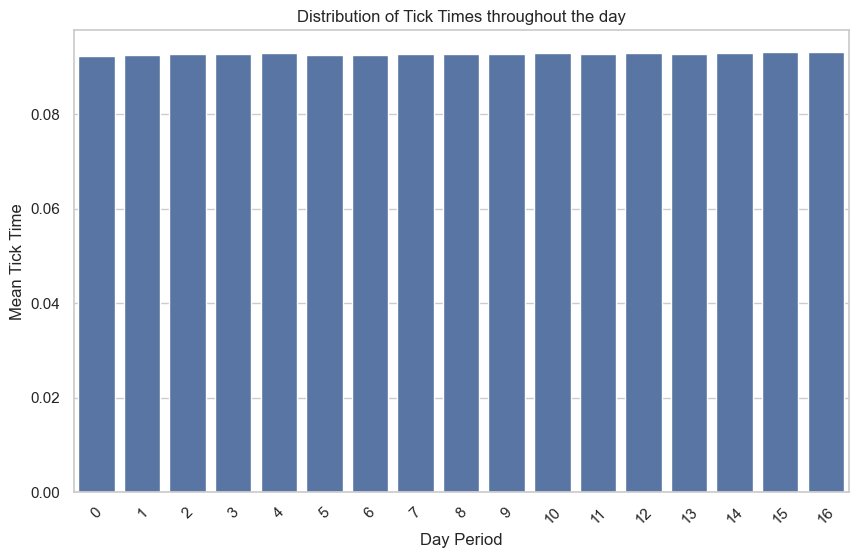

In [121]:
# Calculate the average tick time by period
average_ticktime_by_day_period = lob.groupby('Day_Period')['Tick_Time'].mean()

# Reset the index to have 'Day_Period' as a column
average_ticktime_by_day_period = average_ticktime_by_day_period.reset_index()

# Scatterplot of Mean Mid_Price by Day
plt.figure(figsize=(10, 6))
sns.barplot(data=average_ticktime_by_day_period, x='Day_Period', y='Tick_Time')
plt.title('Distribution of Tick Times throughout the day')
plt.xlabel('Day Period')
plt.ylabel('Mean Tick Time')
plt.xticks(rotation=45)
plt.show()

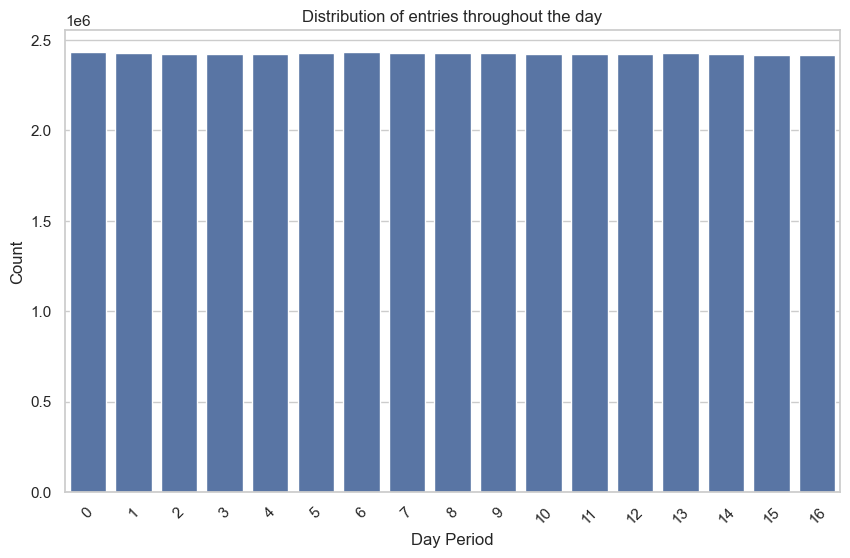

In [122]:
number_of_entries_by_day_period = lob.groupby('Day_Period')['Timestamp'].count()

# Reset the index to have 'Day_Period' as a column
number_of_entries_by_day_period = number_of_entries_by_day_period.reset_index()

# Scatterplot of Mean Mid_Price by Day
plt.figure(figsize=(10, 6))
sns.barplot(data=number_of_entries_by_day_period, x='Day_Period', y='Timestamp')
plt.title('Distribution of entries throughout the day')
plt.xlabel('Day Period')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [123]:
# Group by date and count the number of ticks (number of entries) 
ticks_by_date = lob.groupby('Date')['Timestamp'].count()
ticks_by_date.describe()

count       125.000000
mean     329838.016000
std       14196.019889
min      310089.000000
25%      320397.000000
50%      324425.000000
75%      332729.000000
max      371630.000000
Name: Timestamp, dtype: float64

_Mid-Price_

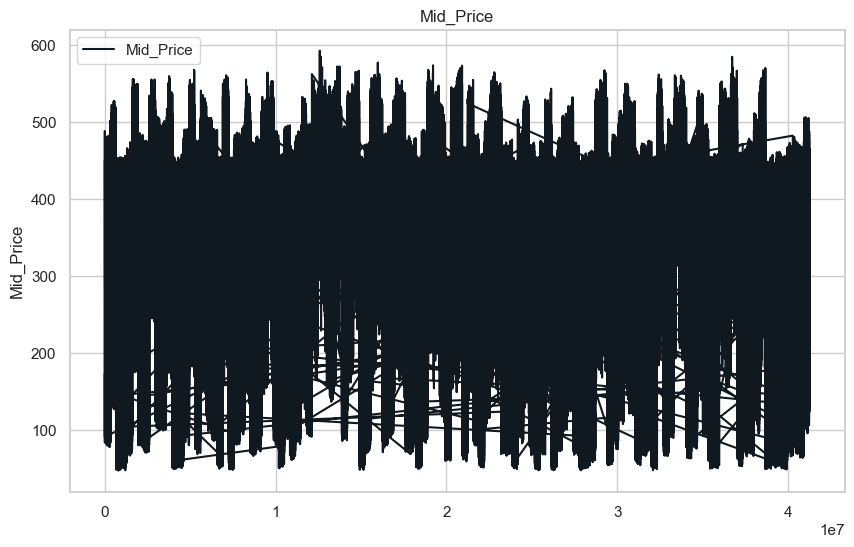

In [124]:
#Mid_Price by index
#lineplot
plt.figure(figsize=(10, 6))
plt.plot(lob.index, lob['Mid_Price'], label='Mid_Price', color='#101820')

plt.ylabel('Mid_Price')
plt.title('Mid_Price')
plt.legend()
plt.show() #we will need SMA's to see something intelligble

/Users/C289216/miniconda3/envs/datasci/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


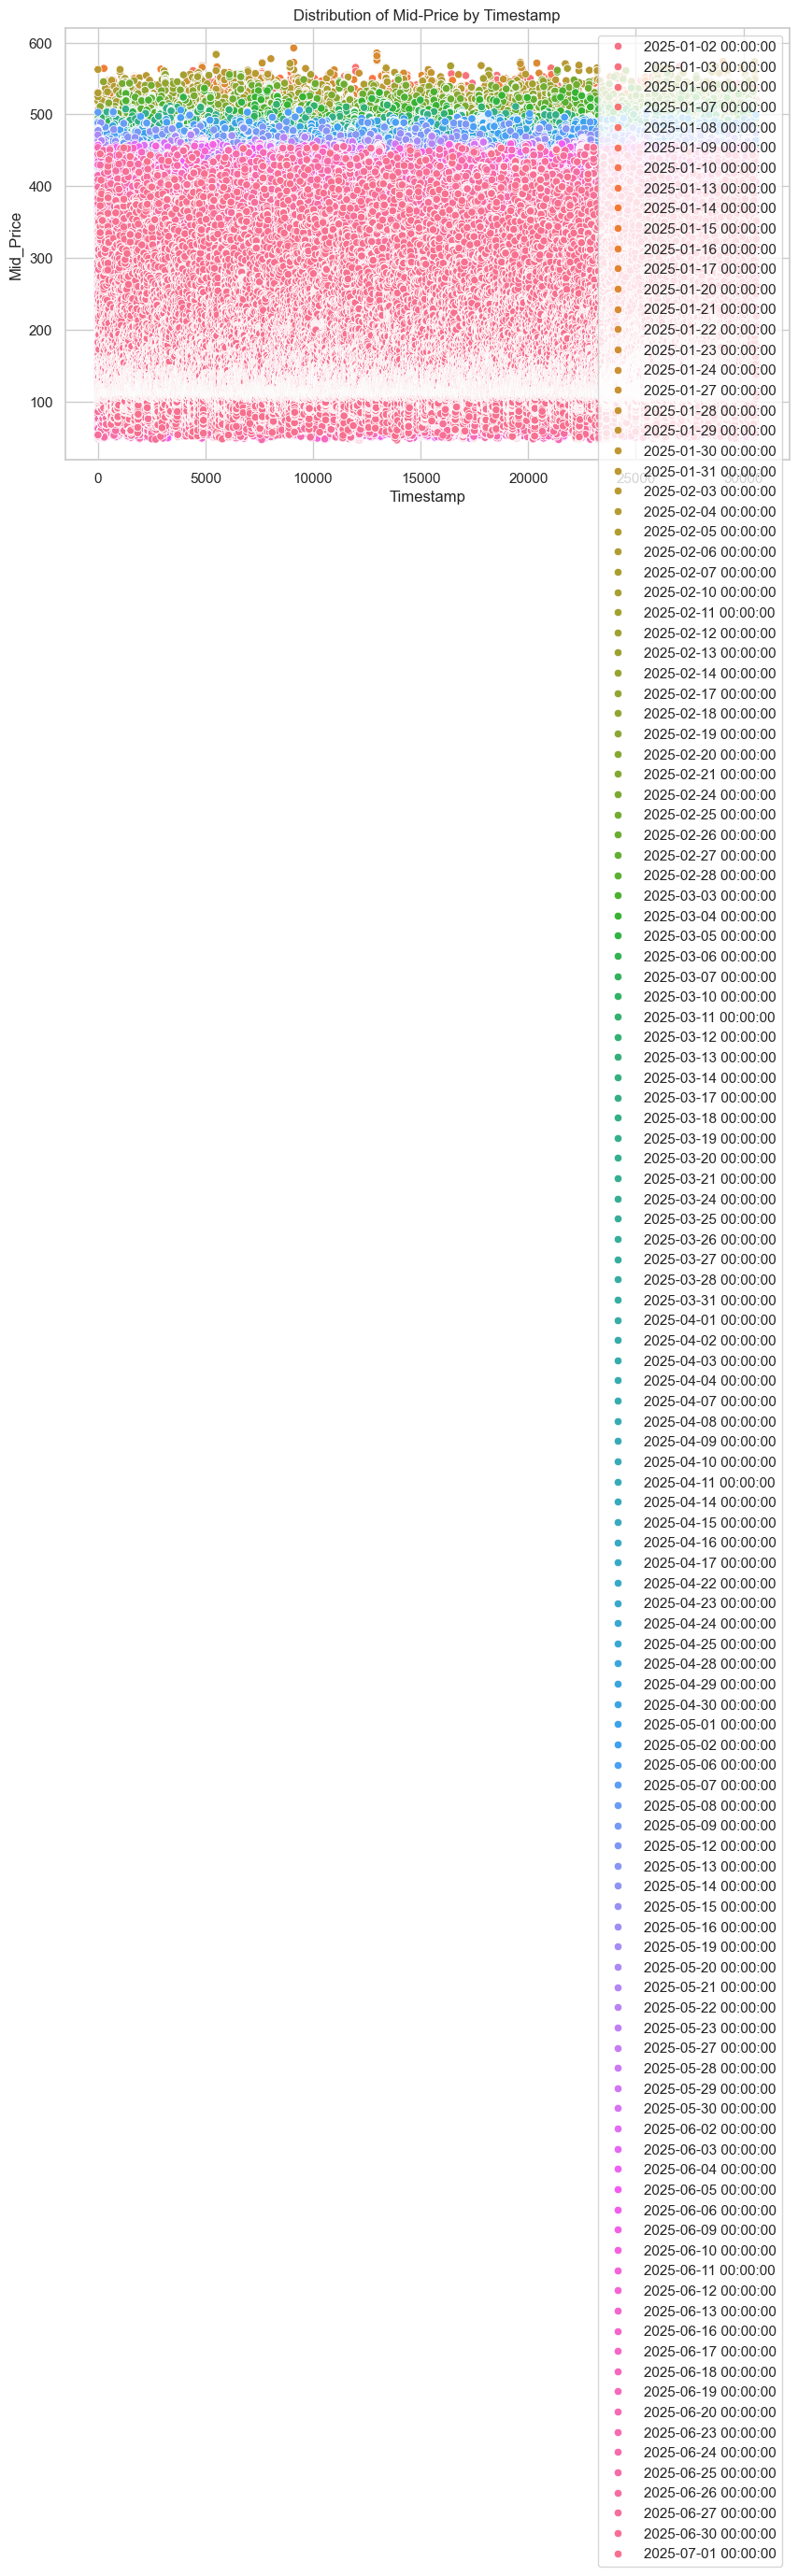

In [125]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=lob['Timestamp'], y=lob['Mid_Price'], hue=lob['Date'])

plt.ylabel('Mid_Price')
plt.xlabel('Timestamp')
plt.title('Distribution of Mid-Price by Timestamp')
plt.legend()
plt.show()

/var/folders/8b/nnqddvld60bdl36420tfgj5m0000gn/T/ipykernel_42770/1747535485.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=lob['Date'].dt.day_name(), y=lob['Mid_Price'], palette=palette)


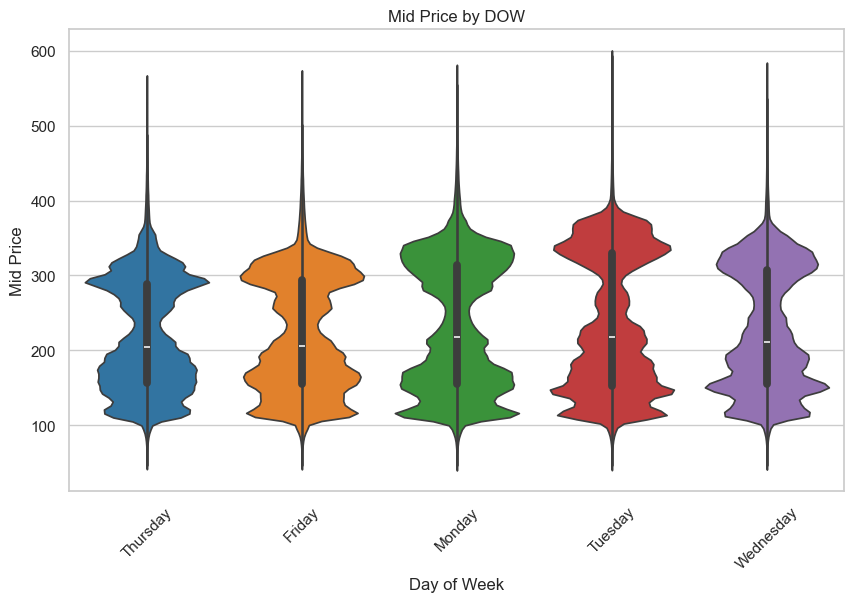

/var/folders/8b/nnqddvld60bdl36420tfgj5m0000gn/T/ipykernel_42770/1747535485.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=lob['Date'].dt.month_name(), y=lob['Mid_Price'], palette=palette)


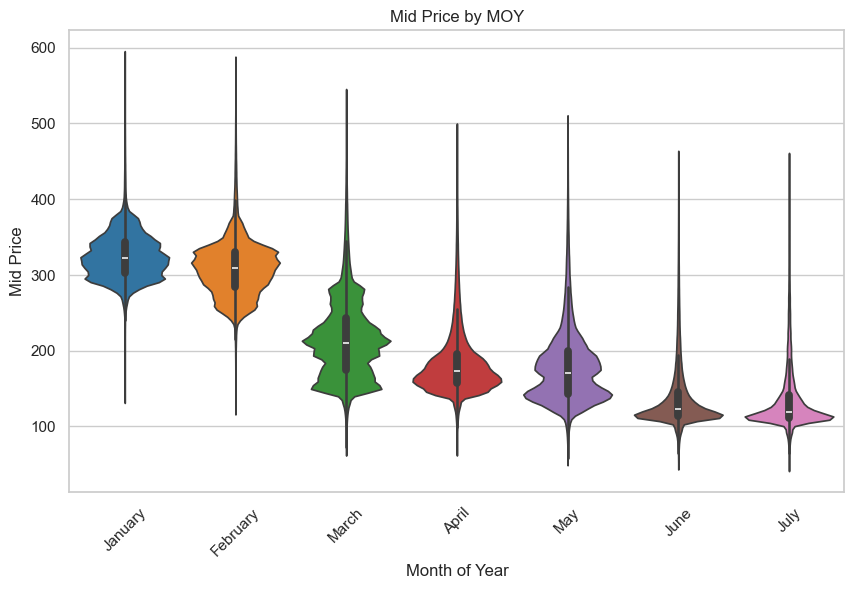

In [126]:
#what's the distribution of mid_price like by day of week or month? 
palette = "tab10"

#vplot of 'Mid price by dow
plt.figure(figsize=(10, 6))
sns.violinplot(x=lob['Date'].dt.day_name(), y=lob['Mid_Price'], palette=palette)
plt.title('Mid Price by DOW')
plt.xlabel('Day of Week')
plt.ylabel('Mid Price')
plt.xticks(rotation=45)
plt.show()

#vplot of Midprice' by moy
plt.figure(figsize=(10, 6))
sns.violinplot(x=lob['Date'].dt.month_name(), y=lob['Mid_Price'], palette=palette)
plt.title('Mid Price by MOY')
plt.xlabel('Month of Year')
plt.ylabel('Mid Price')
plt.xticks(rotation=45)
plt.show() #Not great as we only have 3 days of data from one month but will be good to see on whole set

Some interesting differences in day with just the sample- I wont draw conclusions here though as patterns could be very different with whole set. Median across days seems fairly close. Friday seems to have a wider range, indicating more variation in mid prices for this day. Some outliers on Friday and Monday that would be good to identify. Thursdays distribution is fairly symmetrical whereas Friday/Monday have slight asymmetries. Monday is slightly left-skewed and Friday right-skewed.

In [127]:
# Calculate the average mid price by period
average_midprice_by_day_period = lob.groupby(['Day_Period', 'Date'])['Mid_Price'].mean()

# Reset the index to have 'Day_Period' as a column
average_midprice_by_day_period = average_midprice_by_day_period.reset_index()

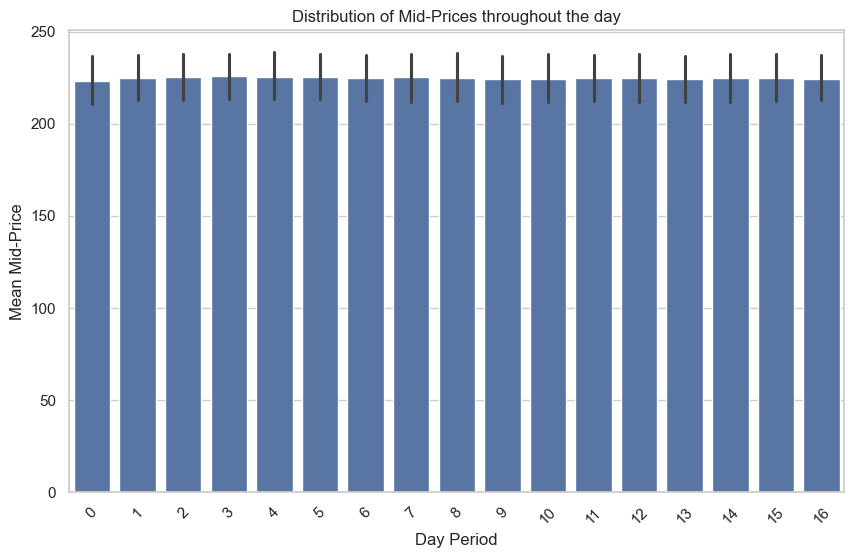

In [128]:
# plot distribution of mid price throughout the day
plt.figure(figsize=(10, 6))
sns.barplot(data=average_midprice_by_day_period, x='Day_Period', y='Mid_Price')
plt.title('Distribution of Mid-Prices throughout the day')
plt.xlabel('Day Period')
plt.ylabel('Mean Mid-Price')
plt.xticks(rotation=45)
plt.show()

__How is the Mid-Price changing over the course of the data?__

This may impact the models ability to adapt to different market conditions. This will become more usefull will all of the data. 

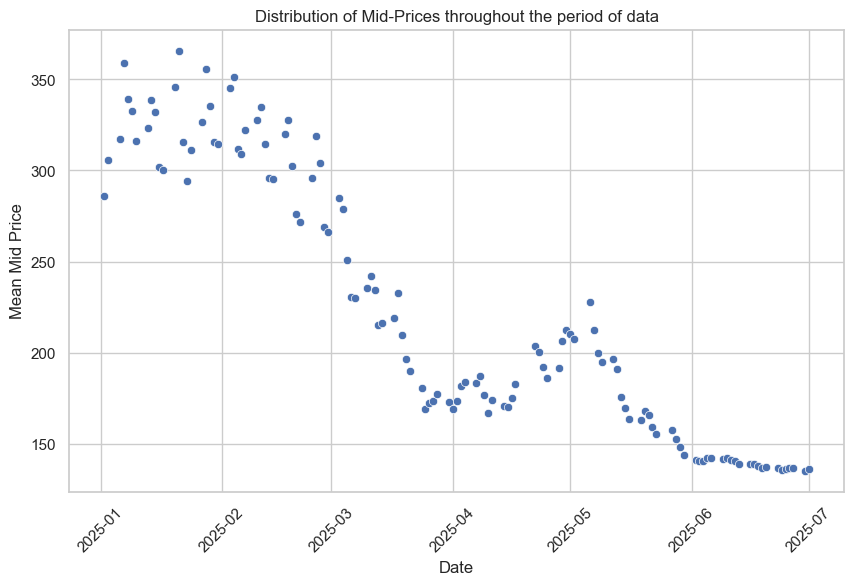

In [129]:
# Calculate the average Mid-Price by period
average_midprice_by_day = lob.groupby('Date')['Mid_Price'].mean()

# Reset the index
average_midprice_by_day = average_midprice_by_day.reset_index()

# Scatterplot of Mean Mid_Price by Day
plt.figure(figsize=(10, 6))
sns.scatterplot(data=average_midprice_by_day, x='Date', y='Mid_Price')
plt.title('Distribution of Mid-Prices throughout the period of data')
plt.xlabel('Date')
plt.ylabel('Mean Mid Price')
plt.xticks(rotation=45)
plt.show()

How balanced is our data between increase and decrease in price? Investigate further with full dataset.

_Bid/Ask_

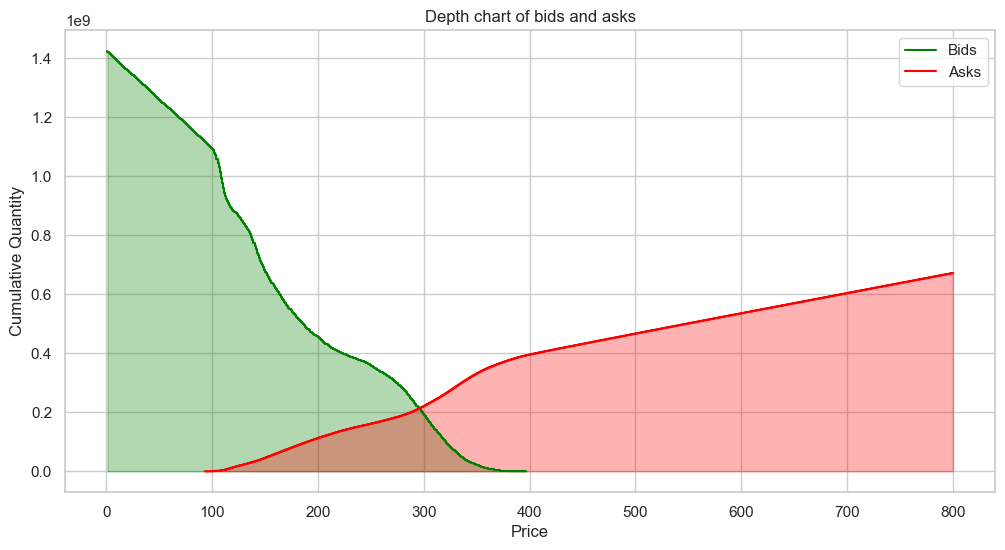

In [130]:
#bid/ask depth
from collections import defaultdict

#default dict to sum quantities for each price level
bid_price_levels = defaultdict(int)
ask_price_levels = defaultdict(int)

#sum quantities for each bid price level
for bid_list in lob['Bid']:
    for price, quantity in bid_list:
        bid_price_levels[price] += quantity

#sum quantities for each ask price level
for ask_list in lob['Ask']:
    for price, quantity in ask_list:
        ask_price_levels[price] += quantity

#convert dictionaries to lists and sort
bid_prices, bid_quantities = zip(*sorted(bid_price_levels.items(), reverse=True))
ask_prices, ask_quantities = zip(*sorted(ask_price_levels.items()))


#calc cumulative quantities for bids and asks
cumulative_bid_quantities = np.cumsum(bid_quantities)
cumulative_ask_quantities = np.cumsum(ask_quantities)

#plot
plt.figure(figsize=(12, 6))

#bids in descending order of price
plt.step(bid_prices, cumulative_bid_quantities, where='post', label='Bids', color='green')

#asks in ascending order of price
plt.step(ask_prices, cumulative_ask_quantities, where='post', label='Asks', color='red')

plt.fill_between(bid_prices, 0, cumulative_bid_quantities, step='post', alpha=0.3, color='green')
plt.fill_between(ask_prices, 0, cumulative_ask_quantities, step='post', alpha=0.3, color='red')

plt.title('Depth chart of bids and asks')
plt.xlabel('Price')
plt.ylabel('Cumulative Quantity')
plt.legend()
plt.grid(True)

I'm new to interpreting bid ask depth graphs but it appears there's a significant amount of liquidity on the bid side at lower prices (large green area) and less liquidity on the ask side at higher prices (narrower red area). The market has more buyers at lower prices and fewer sellers at higher prices up to a certain point, after which the number of sellers increases as the price continues to rise. So buyers hope to purchase at lower prices and sellers aim to sell at higher prices? I THINK

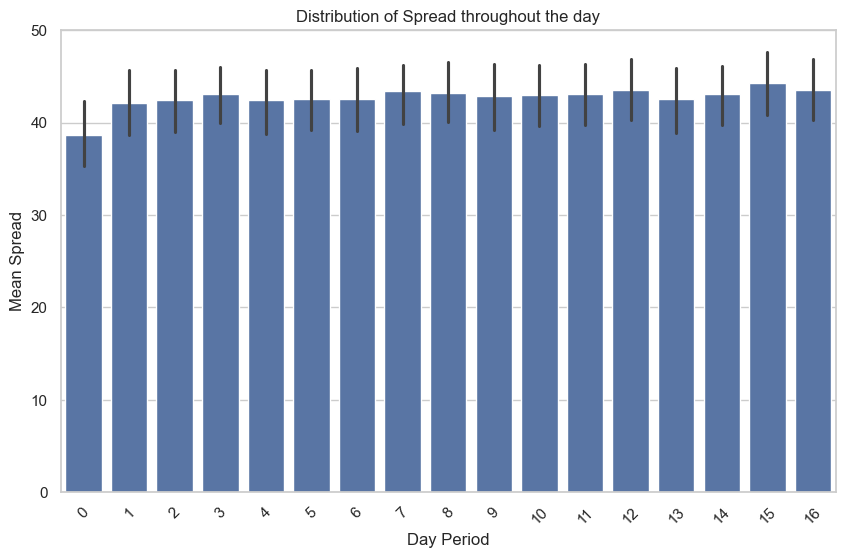

In [131]:
# Calculate spread (assuming best bid is highest price and best ask is lowest price) - from Sam
lob['Spread'] = lob.apply(lambda row: (min(item[0] for item in row['Ask']) - max(
    item[0] for item in row['Bid'])) if row['Bid'] and row['Ask'] else np.nan, axis=1)

# Calculate the average spread by period
average_spread_by_day_period = lob.groupby(['Day_Period', 'Date'])['Spread'].mean()

# Reset the index to have 'Day_Period' as a column
average_spread_by_day_period = average_spread_by_day_period.reset_index()

# plot distribution of spread throughout the day
plt.figure(figsize=(10, 6))
sns.barplot(data=average_spread_by_day_period, x='Day_Period', y='Spread')
plt.title('Distribution of Spread throughout the day')
plt.xlabel('Day Period')
plt.ylabel('Mean Spread')
plt.xticks(rotation=45)
plt.show()

 [Return to contents](#Contents)<br>

## Outliers

_Mid_price outliers_

In [132]:
#calc Q1, Q3, and IQR
Q1 = lob['Mid_Price'].quantile(0.25)
Q3 = lob['Mid_Price'].quantile(0.75)
IQR = Q3 - Q1

#outlier critieria
outliers_criteria = ((lob['Mid_Price'] < (Q1 - 1.5 * IQR)) | (lob['Mid_Price'] > (Q3 + 1.5 * IQR)))

#filter 
outliers = lob[outliers_criteria]

print("Number of mid_price outliers detected-", outliers.shape[0])
print("Percentage of dataset:", (outliers.shape[0]/len(lob)))

Number of mid_price outliers detected- 4192
Percentage of dataset: 0.00010167415025925938


/Users/C289216/miniconda3/envs/datasci/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


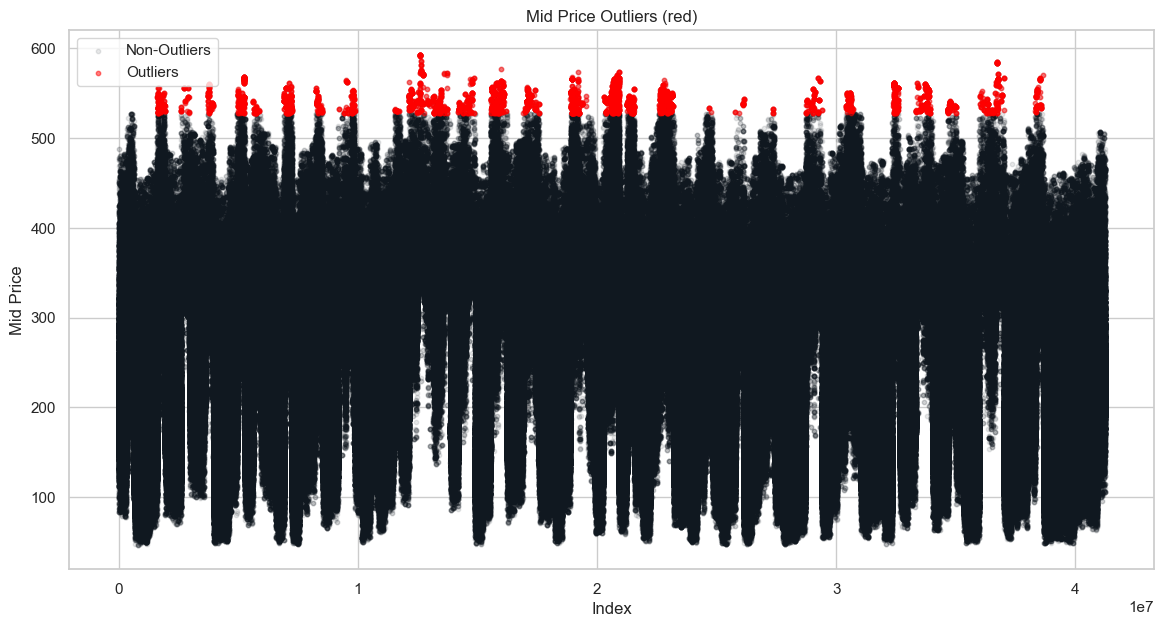

In [133]:
#visualise outliers
plt.figure(figsize=(14, 7))

#non outliers in blue, outliers red
plt.scatter(lob.index, lob['Mid_Price'], s=10, label='Non-Outliers', color='#101820', alpha=0.1)
plt.scatter(outliers.index, outliers['Mid_Price'], s=10, label='Outliers', color='red', alpha=0.5)

plt.title('Mid Price Outliers (red)')
plt.xlabel('Index')
plt.ylabel('Mid Price')
plt.legend()
plt.grid(True)
plt.show()

This feels like looks like a lot and more than 4.7%. Do we need to decrease our definition of outlier? Or use z scores instead? 

In [134]:
#to remove if we agree on this methodology?
#lob = lob[~outliers_criteria]

 [Return to contents](#Contents)<br>

## Financial Technical Indicators

__Trend ("trend is your friend")__

- _Upward_ bullish
- _Downward_ bearish

- Simple Moving Average- SMA- fundamental- smooth out price data and identify trends for specified period- very reliable and filter out noise<br>
<br>
- Exponential SMA- place greater emphasis on recent price data- more responsive to trend changing than SMA <br>
<br>
- ADX average directional index- determine strength of trend- first have to calc the directional movement index. ranges from 0-100. 0-20- weak trend avoid trading. 20-40 developing trend. 40-60 relatively strong trend. 60-100 extremely strong trend. Be careful here too though as when trends are fast e.g. above 80 you have a high volatility market. Or can mean lots of noise. optimal 40-60. Confirm using other indicators. ADX doesnt tell us about direction JUST strength. <br>

In [135]:
#SMA
#10 (short) and 50 (long) are standard meaures
lob['SMA_Short'] = lob['Mid_Price'].rolling(window=10).mean() 
lob['SMA_Long'] = lob['Mid_Price'].rolling(window=50).mean() 

#may want to resample for daily?

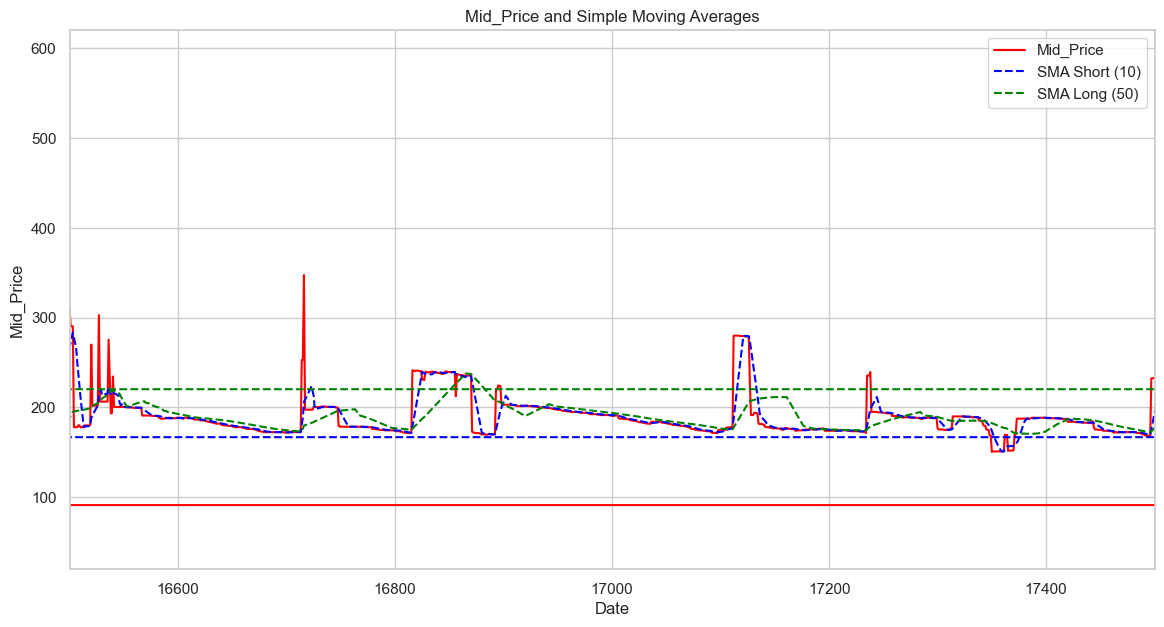

In [136]:
#visualise
plt.figure(figsize=(14, 7))

plt.plot(lob.index, lob['Mid_Price'], label='Mid_Price', color='red')
plt.plot(lob.index, lob['SMA_Short'], label='SMA Short (10)', color='blue',linestyle='--')
plt.plot(lob.index, lob['SMA_Long'], label='SMA Long (50)', color='green',linestyle='--')

#truncate to see pattern
start_index = 16500  
end_index = 17500  
plt.xlim(start_index, end_index)

plt.xlabel('Date')
plt.ylabel('Mid_Price')
plt.title('Mid_Price and Simple Moving Averages')
plt.legend()
plt.show()

In [137]:
#EMA
lob['EMA_Short'] = lob['Mid_Price'].ewm(span=10, adjust=False).mean()
lob['EMA_Long'] = lob['Mid_Price'].ewm(span=50, adjust=False).mean()

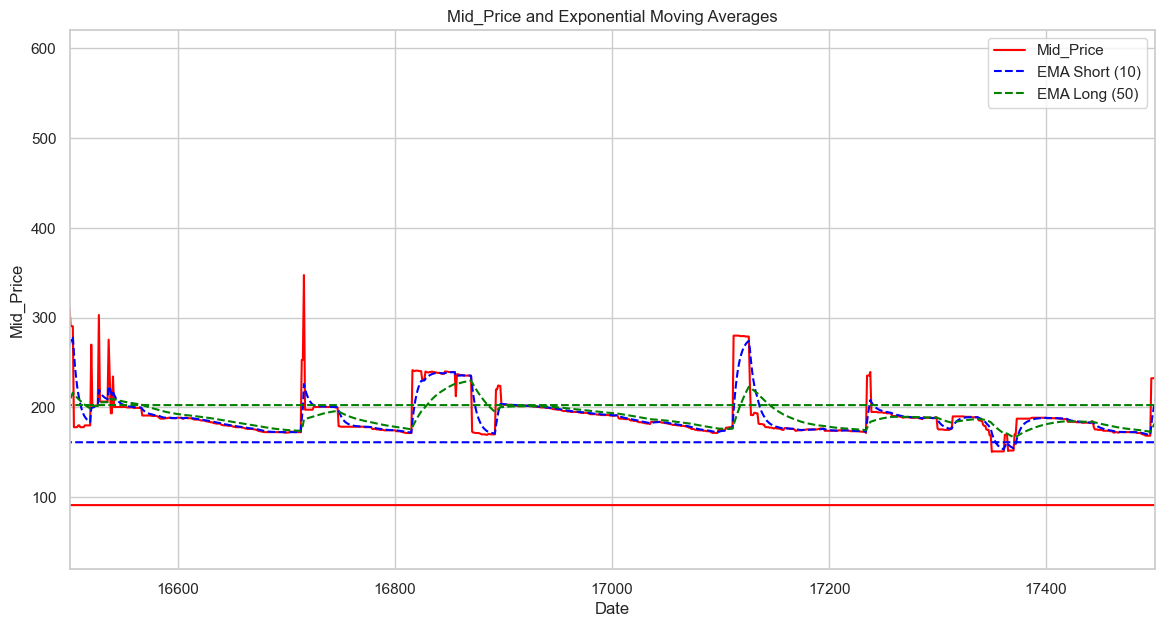

In [138]:
#visualise
plt.figure(figsize=(14, 7))

plt.plot(lob.index, lob['Mid_Price'], label='Mid_Price', color='red')
plt.plot(lob.index, lob['EMA_Short'], label='EMA Short (10)', color='blue',linestyle='--')
plt.plot(lob.index, lob['EMA_Long'], label='EMA Long (50)', color='green',linestyle='--')

#truncate to see pattern
start_index = 16500  
end_index = 17500  
plt.xlim(start_index, end_index)

plt.xlabel('Date')
plt.ylabel('Mid_Price')
plt.title('Mid_Price and Exponential Moving Averages')
plt.legend()
plt.show()

In [139]:
#ADX not possible without the actual high low and close prices for each period.

__Momentum__
- essential for understanding speed and power of price movements
- RSI-popular- overbought and oversold conditions-calculates with avg gain, avg loss and relative strength. You need to check direction not just value to understand trend. (see below img)

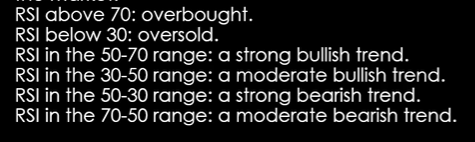

In [140]:
#rsi
delta = lob['Mid_Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss

lob['RSI'] = 100 - (100 / (1 + RS))

In [141]:
lob['RSI'].describe().round(2)

count    39451994.00
mean           33.18
std            36.61
min             0.00
25%             0.00
50%            20.00
75%            60.00
max           100.00
Name: RSI, dtype: float64

In [142]:
#we cant calculate stochastic oscillator as no high low close etc

__Volatility__

- very useful for algorithmic trading
- help trades understand the degree of prics fluctuations. price change per time unit. high v- price is changing quite fast. low v- price is changing quite slow
- Bollinger Bands- moveing average calc over specified period e.g. 20 days. + bands for moving average + or - 2 Standard deviations. (Could be 1.5 or 2.5) 1.9-2.2 is usual for algorithmic trading. Identify volatility and potential trend reversals. When prices are near the upper band the asset may be overbought indicating a possible reversal or pullback. When prices are near the lower band- asset may be oversold suggesting a upward reversal.

In [143]:
#bollinger bands
MA = lob['Mid_Price'].rolling(window=20).mean() #over 20 periods
SD = lob['Mid_Price'].rolling(window=20).std()

lob['Upper_BB'] = MA + (2 * SD) #upper bb
lob['Lower_BB'] = MA - (2 * SD) #lower bb

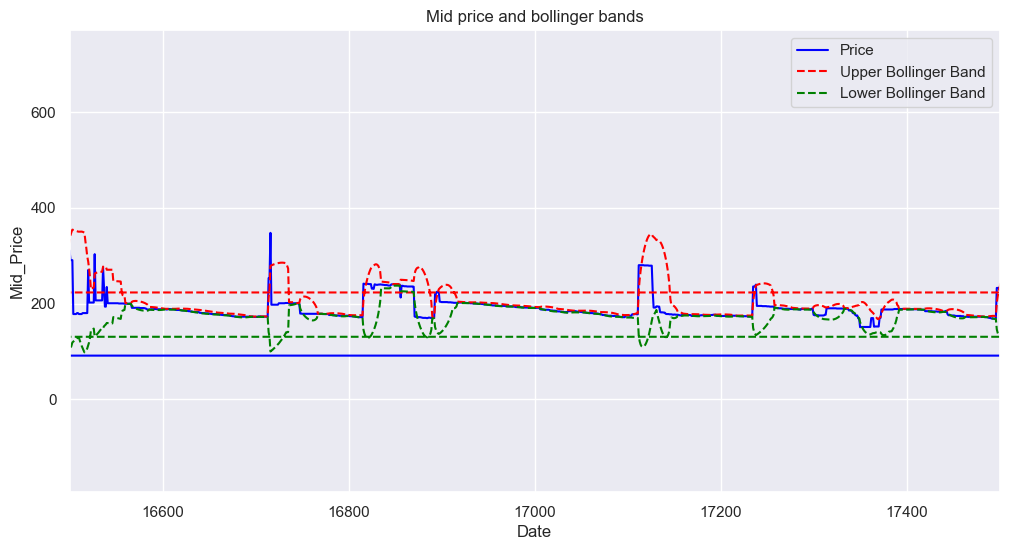

In [144]:
#plot
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.plot(lob.index, lob['Mid_Price'], label='Price', color='blue')
plt.plot(lob.index, lob['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(lob.index, lob['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#truncate to see pattern
start_index = 16500  
end_index = 17500  
plt.xlim(start_index, end_index)

plt.xlabel('Date')
plt.ylabel('Mid_Price')
plt.title('Mid price and bollinger bands')
plt.legend()

plt.show()

In [145]:
#cant calc average true range as no high low close etc

__Volume__

- High volume- good indicator that more traders are entering exiting the market- high liquidity
- OBV -on balance volume- confirm trends by analysing volume changes. Persistnet rising obv suggests accumulation / buying pressure- associated with upward price movement. Persistent falling obv suggests distribution /selling pressure. Theory is that changes in volume preced price movements. Increase in volume often precedes a change in price direction. Use as trend,reversal and breakout confirmation.

- If today's close is higher than yesterday's close, then OBV = Previous OBV + today's volume.
- If today's close is lower than yesterday's close, then OBV = Previous OBV - today's volume.
- If today's close is equal to yesterday's close, then OBV = Previous OBV.

In [146]:
#obv
#should be done using close but we can approximate with mid but might not be as reliable

#need volume to calculate (NEED TO CHECK THIS METHOD)
lob['Volume'] = lob['Bid'].apply(lambda x: sum([qty for price, qty in x])) + \
               lob['Ask'].apply(lambda x: sum([qty for price, qty in x]))

#calc obv
direction = lob['Mid_Price'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
lob['OBV'] = (direction * lob['Volume']).cumsum()

In [147]:
#cant calculate chakin money flow without high low close etc

In [148]:
#VWAP might be good too but we would need to resample for daily
#gives an average price a security has traded at throughout the day, based on both volume and price.
#e.g. tape['VWAP'] = (tape['Price'] * tape['Quantity']).cumsum() / tape['Quantity'].cumsum()

In [149]:
#maybe also fourier transforms for long term cycles/trends
#FFT = np.fft.fft(np.asarray(tape['Price'].tolist()))
#FFT_real = np.real(FFT)
#tape['FFT'] = FFT_real

In [150]:
#would lag features be useful?

__Depth__

In [151]:
#so we have volume but

In [152]:
#if we need a more complex calculation of depth (eg only orders within a certain price range of the mid price)
#we could try something like
def sum_volumes_in_range(order_list, mid_price, percentage_range):
    #price range based on the percentage
    lower_bound = mid_price * (1 - percentage_range)
    upper_bound = mid_price * (1 + percentage_range)
    
    #sum volumes where the price is within range
    return sum(volume for price, volume in order_list if lower_bound <= price <= upper_bound)

percentage_range = 0.10

lob['Depth'] = lob.apply(lambda row: sum_volumes_in_range(row['Bid'], row['Mid_Price'], percentage_range) +
                                     sum_volumes_in_range(row['Ask'], row['Mid_Price'], percentage_range), axis=1)

In [153]:
lob.head()

,Timestamp,Date,Exchange,Bid,Ask,Mid_Price,Tick_Time,Day_Period,Spread,SMA_Short,SMA_Long,EMA_Short,EMA_Long,RSI,Upper_BB,Lower_BB,Volume,OBV,Depth
25781999,1.333,2025-01-02,Exch0,"[[1, 6]]","[[800, 1]]",400.5,NaN,0,799,NaN,NaN,400.500000,400.500000,NaN,NaN,NaN,7,0,0
25782000,1.581,2025-01-02,Exch0,"[[1, 6]]","[[799, 1]]",400.0,0.248,0,798,NaN,NaN,400.409091,400.480392,NaN,NaN,NaN,7,-7,0
25782001,1.643,2025-01-02,Exch0,"[[1, 6]]","[[798, 1]]",399.5,0.062,0,797,NaN,NaN,400.243802,400.441945,NaN,NaN,NaN,7,-14,0
25782002,1.736,2025-01-02,Exch0,"[[261, 1], [1, 6]]","[[798, 1]]",529.5,0.093,0,537,NaN,NaN,423.744929,405.503046,NaN,NaN,NaN,8,-6,0
25782003,1.984,2025-01-02,Exch0,"[[261, 1], [1, 6]]","[[797, 1]]",529.0,0.248,0,536,NaN,NaN,442.882214,410.346063,NaN,NaN,NaN,8,-14,0


In [154]:
# #save lob (in Jupyter env)
# lob.to_csv('lob.csv', index=False)

 [Return to contents](#Contents)<br>

__??Transform__

In [155]:
#import required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np

In [156]:
#normalise- scaling data to range between 0 and 1
scaler = MinMaxScaler()
lob['Normalised_Mid_Price'] = scaler.fit_transform(lob[['Mid_Price']])

In [157]:
#standardise- scaling data to mean of 0 and standard deviation of 1)
scaler = StandardScaler()
lob['Standardised_Mid_Price'] = scaler.fit_transform(lob[['Mid_Price']])

 [Return to contents](#Contents)<br>